In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Load dataset
df = pd.read_csv("customer_feedback_satisfaction.csv")

In [4]:
df.head(5)

Age  Gender          Region  NetworkCoverage  InternetSpeed  \
0   56    Male       Karnataka                8              1   
1   50    Male  Andhra Pradesh                3              3   
2   42  Female       Telangana                7              2   
3   45    Male          Kerala                3              5   
4   30    Male          Kerala                1              3   

   CustomerSupport  AppExperience  PlanSatisfaction  CallQuality  Duration  \
0                4              6                 8            6       9.2   
1                9              5                 4            5       4.3   
2               10              2                 5            3       4.8   
3                1              8                 5            1       7.7   
4                7              3                 1            5       0.9   

                          FeedbackText  SatisfactionScore  
0        Call quality could be better.                 48  
1            Great experience overall.                 57  
2            Great experience overall.                 56  
3  Signal drops frequently in my area.                 37  
4       Poor network coverage indoors.                 36

In [4]:
# Data Insights
print("\n Dataset Description:\n")
print(df.describe().T)


 Dataset Description:

                     count       mean        std   min   25%   50%   75%  \
Age                38444.0  41.459343  13.819923  18.0  30.0  41.0  53.0   
NetworkCoverage    38444.0   5.477812   2.870639   1.0   3.0   5.0   8.0   
InternetSpeed      38444.0   5.511523   2.869242   1.0   3.0   6.0   8.0   
CustomerSupport    38444.0   5.518182   2.871980   1.0   3.0   6.0   8.0   
AppExperience      38444.0   5.512720   2.872598   1.0   3.0   6.0   8.0   
PlanSatisfaction   38444.0   5.519145   2.869129   1.0   3.0   6.0   8.0   
CallQuality        38444.0   5.498231   2.874916   1.0   3.0   5.0   8.0   
Duration           38444.0   5.253969   2.740258   0.5   2.9   5.3   7.6   
SatisfactionScore  38444.0  55.160805  16.796362   5.0  43.0  55.0  67.0   

                     max  
Age                 65.0  
NetworkCoverage     10.0  
InternetSpeed       10.0  
CustomerSupport     10.0  
AppExperience       10.0  
PlanSatisfaction    10.0  
CallQuality         10.0  

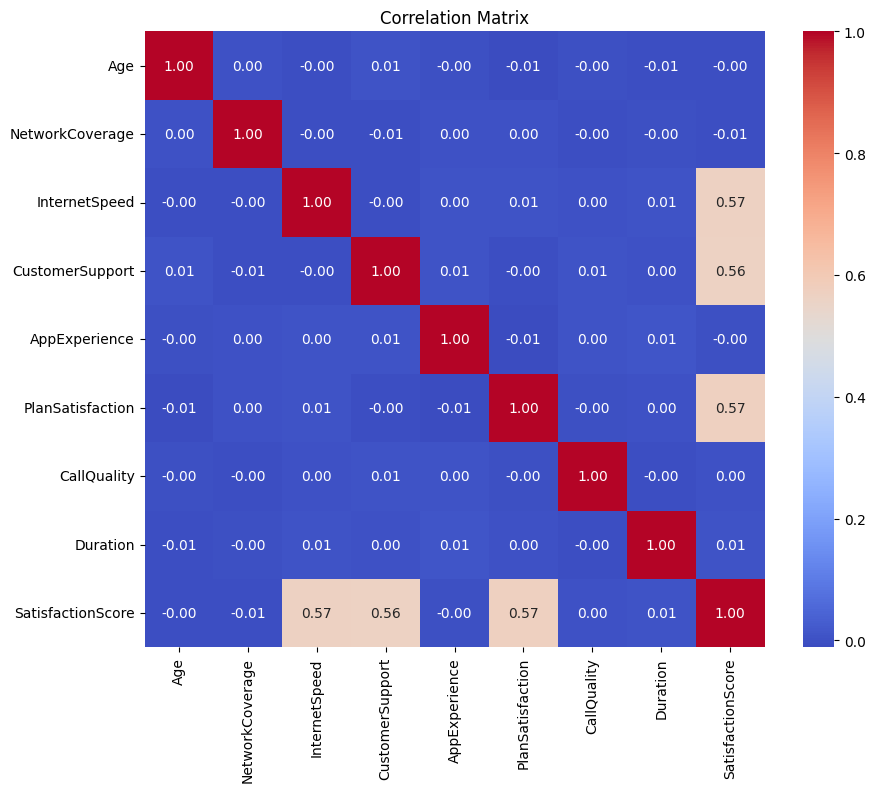

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [6]:
if "FeedbackText" in df.columns:
    df.drop("FeedbackText", axis=1, inplace=True)


In [7]:
# Feature/Target split
X = df.drop("SatisfactionScore", axis=1)
y = df["SatisfactionScore"]


In [8]:
# Identify and encode categorical columns first
label_columns = ["Gender", "Region"]  # or ["Gender", "Country"] based on your data
for col in label_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Apply label encoding BEFORE scaling

# Now it's safe to scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as 'scaler.pkl'")


✅ Scaler saved as 'scaler.pkl'


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [11]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "SVM": SVR()
}

In [12]:
# Evaluate models
results = []
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({"Model": name, "MSE": round(mse, 2), "R2 Score": round(r2, 4)})
    except Exception as e:
        results.append({"Model": name, "MSE": "Error", "R2 Score": str(e)})

In [13]:
# Display results
results_df = pd.DataFrame(results)
print("\n📈 Model Comparison Results:\n")
print(results_df.sort_values(by="R2 Score", ascending=False).to_string(index=False))


📈 Model Comparison Results:

              Model   MSE  R2 Score
  Linear Regression  8.34    0.9705
            XGBoost  9.33    0.9670
      Random Forest 10.00    0.9646
                SVM 10.16    0.9641
Logistic Regression 12.74    0.9550
           AdaBoost 14.90    0.9473
      Decision Tree 17.58    0.9378


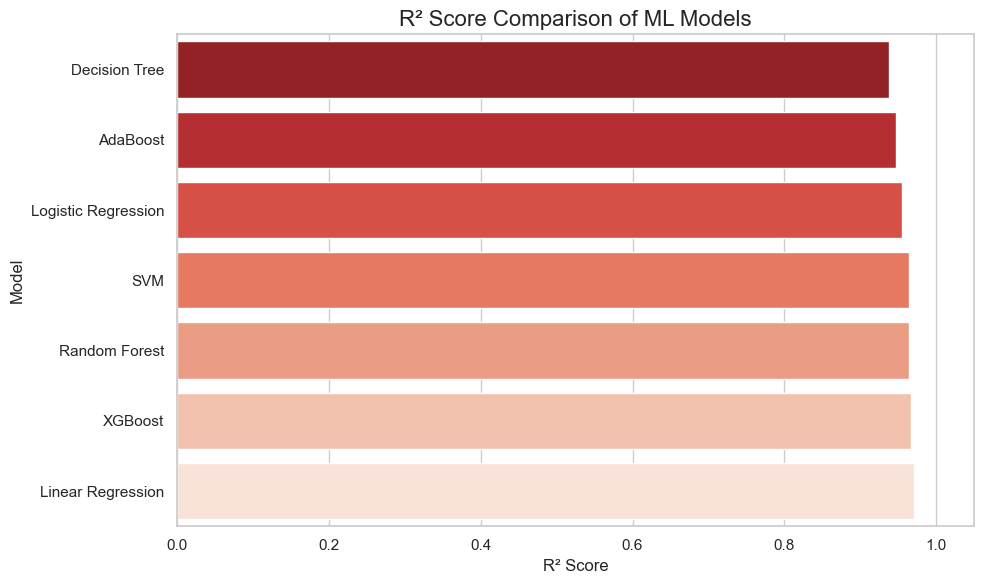

In [14]:
# Set clean style
sns.set(style="whitegrid")

# Prepare data
results_df_sorted = results_df[results_df["R2 Score"] != "Error"].sort_values(by="R2 Score", ascending=True)
results_df_sorted["R2 Score"] = results_df_sorted["R2 Score"].astype(float)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="R2 Score",
    y="Model",
    data=results_df_sorted,
    hue="Model",       # <- Add this for proper palette support
    dodge=False,
    palette="Reds_r",
    legend=False
)
plt.title("R² Score Comparison of ML Models", fontsize=16)
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

In [15]:
#  Save the Best Model (Linear Regression)
final_model = LinearRegression()
final_model.fit(X_scaled, y)
joblib.dump(final_model, "customer_satisfaction_linear_model.pkl")
print("\nFinal Linear Regression model saved as 'customer_satisfaction_linear_model.pkl'")


Final Linear Regression model saved as 'customer_satisfaction_linear_model.pkl'


In [16]:
# ------------------------------
# 📊 TOP 5 DATA INSIGHTS
# ------------------------------
print("\nTop 5 Insights from the Dataset:\n")
print("1. Average Satisfaction Score:", df["SatisfactionScore"].mean())
print("2. Most Common Region:", df["Region"].mode()[0])
print("3. Average Duration with Airtel:", df["Duration"].mean())
print("4. Top Rated Service Aspect:", df[["NetworkCoverage", "InternetSpeed", "CustomerSupport",
       "AppExperience", "PlanSatisfaction", "CallQuality"]].mean().idxmax())
print("5. Gender Distribution:")
print(df["Gender"].value_counts())


Top 5 Insights from the Dataset:

1. Average Satisfaction Score: 55.16080532722922
2. Most Common Region: Telangana
3. Average Duration with Airtel: 5.253969410050984
4. Top Rated Service Aspect: PlanSatisfaction
5. Gender Distribution:
Gender
Female    19412
Male      19032
Name: count, dtype: int64


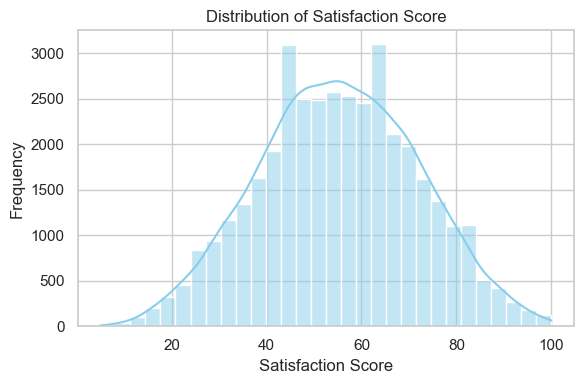

In [17]:
# ------------------------------
# 📈 DATA VISUALIZATION
# ------------------------------
sns.set(style="whitegrid")

# 1. Satisfaction Score Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["SatisfactionScore"], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Satisfaction Score")
plt.xlabel("Satisfaction Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

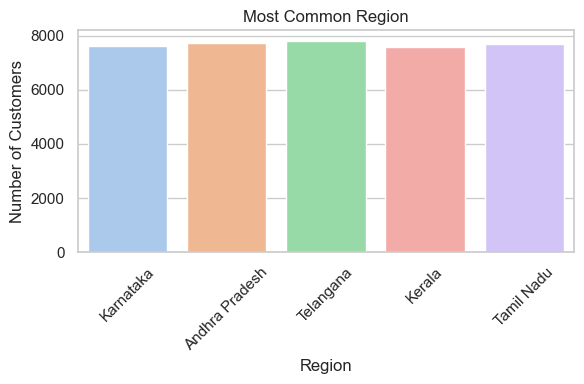

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Region", hue="Region", palette="pastel", legend=False)
plt.title("Most Common Region")
plt.xlabel("Region")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


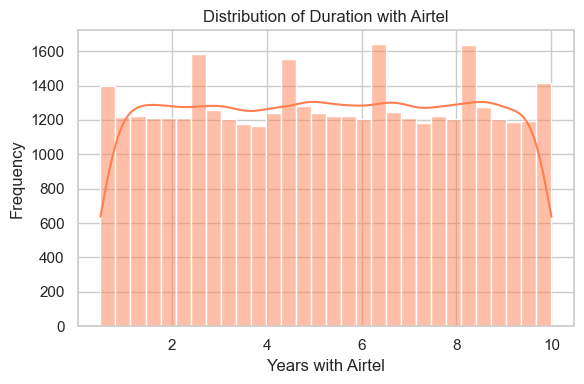

In [19]:
# 3. Duration with Airtel
plt.figure(figsize=(6, 4))
sns.histplot(df["Duration"], bins=30, kde=True, color='coral')
plt.title("Distribution of Duration with Airtel")
plt.xlabel("Years with Airtel")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

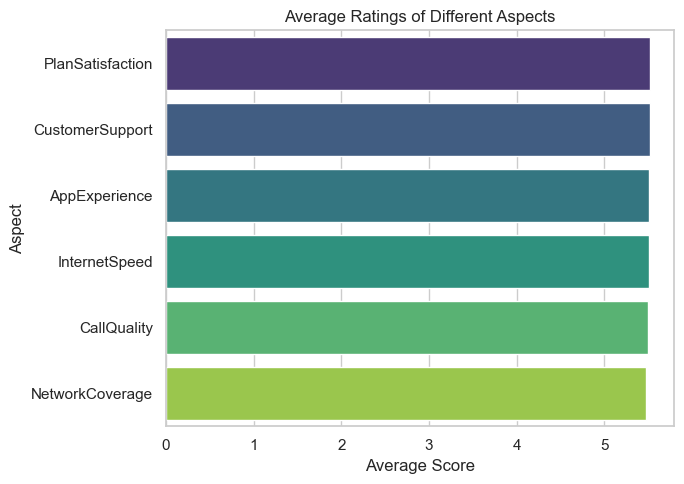

In [24]:
# 4. Mean Scores of Service Aspects
aspects = ["NetworkCoverage", "InternetSpeed", "CustomerSupport",
           "AppExperience", "PlanSatisfaction", "CallQuality"]
mean_scores = df[aspects].mean().sort_values(ascending=False)

aspect_df = mean_scores.reset_index()
aspect_df.columns = ["Aspect", "Score"]

plt.figure(figsize=(7, 5))
sns.barplot(data=aspect_df, x="Score", y="Aspect", hue="Aspect", palette="viridis", legend=False)
plt.title("Average Ratings of Different Aspects")
plt.xlabel("Average Score")
plt.tight_layout()
plt.show()


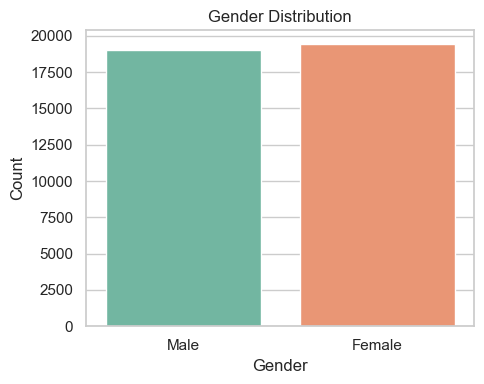

In [23]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="Gender", hue="Gender", palette="Set2", legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
